In [ ]:
#default_exp core

# fastdot.core

> Drawing graphs with graphviz.

In [ ]:
#export
from fastcore.all import *
import pydot
from matplotlib.colors import rgb2hex, hex2color

In [ ]:
#export
_all_ = ['pydot']

In [ ]:
#hide
from nbdev.showdoc import *

## Nodes

In [ ]:
#export
def Dot(defaults=None, rankdir='LR', directed=True, compound=True, **kwargs):
    "Create a `pydot.Dot` graph with fastai/fastdot style defaults"
    return pydot.Dot(rankdir=rankdir, directed=directed, compound=compound, **kwargs)

In [ ]:
#export
def uniq_name(o): return 'n'+(uuid4().hex)

def quote(x, q='"'):
    'Surround `x` with `"`'
    return f'"{x}"'

@patch
def _repr_svg_(self:pydot.Dot):
    return self.create_svg().decode('utf-8')

In [ ]:
#export
graph_objects = {}
object_names = {}

In [ ]:
#export
def add_mapping(graph_item, obj):
    graph_objects[graph_item.get_name()] = graph_item
    object_names[id(obj)] = graph_item.get_name()
    return graph_item

In [ ]:
#export
def _pydot_create(f, obj, **kwargs):
    for k,v in kwargs.items():
        if callable(v): v = kwargs[k] = v(obj)
        if k not in ('name','graph_name'): kwargs[k] = quote(v)
    return add_mapping(f(**kwargs), obj)

In [ ]:
#export
node_defaults = dict(label=str, tooltip=str, name=uniq_name, shape='box', style='rounded, filled', fillcolor='white')

In [ ]:
#export
def Node(obj, **kwargs):
    "Create a `pydot.Node` with a unique name"
    if not isinstance(obj,str) and isinstance(obj, Collection) and len(obj)==2:
        obj,kwargs['tooltip'] = obj
    kwargs = merge(node_defaults, kwargs)
    return _pydot_create(pydot.Node, obj, **kwargs)

`pydot` uses the same name-based approach to identifying graph items as `graphviz`. However we would rather use python objects. Therefore, we patch `pydot` to use unique names.

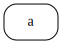

In [ ]:
g = Dot()
a = Node('a')
g.add_node(a)
g

If a 2-tuple is passed to `add_node`, then the 2nd element becomes the tooltip. You can also pass any `kwargs` that are accepted by `graphviz`.

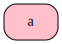

In [ ]:
g = Dot()
g.add_node(Node(['a', "My tooltip"], fillcolor='pink'))
g

Keyword args can also be arbitrary functions, which will called with the node's label.

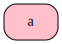

In [ ]:
g = Dot()
o = 'a'
g.add_node(Node(o, fillcolor=lambda o:'pink'))
g

In [ ]:
#export
def object2graph(o):
    "Get graph item representing `o`"
    return graph_objects[object_names[id(o)]]

In [ ]:
object2graph(o).get_fillcolor()

'"pink"'

## Colors

The callable kwargs functionality can be used to map labels to colors in a consistent way..

In [ ]:
#export
def obj2node_color(cm, minalpha, rangealpha, o):
    "Create a consistent mapping from objects to colors, using colormap `cm`"
    h = hash(o)
    i = float(h % 256) / 256
    alpha = (h^hash('something')) % rangealpha + minalpha
    return rgb2hex(cm(i)) + f'{alpha:02X}'

In [ ]:
#exports
graph_colors1 = partial(obj2node_color, plt.get_cmap('rainbow'), 30, 160)
graph_colors2 = partial(obj2node_color, plt.get_cmap('tab20'), 30, 160)

These predefined color mapping functions provide a good range of colors and readable text.

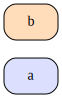

In [ ]:
g = Dot()
g.add_node(Node('a', fillcolor=graph_colors1))
g.add_node(Node('b', fillcolor=graph_colors1))
g

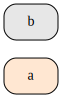

In [ ]:
g = Dot()
g.add_node(Node('a', fillcolor=graph_colors2))
g.add_node(Node('b', fillcolor=graph_colors2))
g

We'll use the former color function as our default. You can change it by simply modifying `node_defaults`.

In [ ]:
#export
node_defaults['fillcolor'] = graph_colors1

## Clusters and Items

In [ ]:
#export
cluster_defaults = dict(label=str, tooltip=str, graph_name=uniq_name, style='rounded, filled', fillcolor='#55555522')

In [ ]:
#export
def Cluster(obj='', **kwargs):
    "Create a `pydot.Cluster` with a unique name"
    kwargs = merge(cluster_defaults, kwargs)
    return _pydot_create(pydot.Cluster, obj, **kwargs)

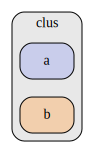

In [ ]:
g = Dot()
sg = Cluster('clus', tooltip='Cluster tooltip')
sg.add_node(Node(['a', "My tooltip"]))
sg.add_node(Node('b'))
g.add_subgraph(sg)
g

In [ ]:
#export
@patch
def nodes(self:pydot.Graph):
    "`i`th node in `Graph`"
    return L(o for o in self.get_nodes() if o.get_label() is not None)

In [ ]:
#export
@patch
def __getitem__(self:pydot.Graph, i):
    "`i`th node in `Graph`"
    return self.nodes()[i]

You can subscript into a `Graph`'s `Node`s by index:

In [ ]:
print(sg[0].get_label())

"a"


In [ ]:
#export
@patch
def add_item(self:pydot.Graph, item, **kwargs):
    "Add a `Cluster`, `Node`, or `Edge` to the `Graph`"
    if not isinstance(item, (pydot.Edge,pydot.Node,pydot.Graph)): item = Node(item, **kwargs)
    f = self.add_node     if isinstance(item, pydot.Node ) else \
        self.add_subgraph if isinstance(item, pydot.Graph) else \
        self.add_edge     if isinstance(item, pydot.Edge ) else None
    f(item)
    return item

There's no good reason to have different methods for adding clusters vs nodes (as `pydot` requires), so we provide a single method.

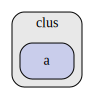

In [ ]:
g = Dot()
sg = Cluster('clus')
g.add_item(sg)
sg.add_item('a')
g

In [ ]:
#export
@patch
def add_items(self:pydot.Graph, *items, **kwargs):
    "Add `items` the `Graph`"
    return L(self.add_item(it, **kwargs) for it in items)

In [ ]:
#export
def graph_items(*items, **kwargs):
    "Add `items` to a new `pydot.Dot`"
    g = Dot()
    g.add_items(*items, **kwargs)
    return g

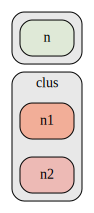

In [ ]:
sg1 = Cluster('clus')
sg1.add_items('n1', 'n2')
sg2 = Cluster()
sg2.add_item('n')
graph_items(sg1,sg2)

## Edges

In [ ]:
#export
@patch
def first(self:pydot.Graph):
    "First node in `Graph`, searching subgraphs recursively as needed"
    nodes = self.nodes()
    if nodes: return nodes[0]
    for subg in self.get_subgraphs():
        res = subg.first()
        if res: return res

In [ ]:
#export
@patch
def last(self:pydot.Graph):
    "Lastt node in `Graph`, searching subgraphs recursively as needed"
    nodes = self.nodes()
    if nodes: return nodes[-1]
    for subg in reversed(self.get_subgraphs()):
        res = subg.last()
        if res: return res

In [ ]:
#export
@patch
def with_compass(self:(pydot.Node,pydot.Graph), compass=None):
    r = self.get_name()
    return f'{r}:{compass}' if compass else r

In [ ]:
# export
@patch
def connect(self:(pydot.Node,pydot.Graph), item, compass1=None, compass2=None, **kwargs):
    "Connect two nodes or clusters"
    a,b,ltail,lhead = self,item,'',''
    if isinstance(self,pydot.Graph):
        a = self.last()
        ltail=self.get_name()
    if isinstance(item,pydot.Graph):
        b = item.first()
        lhead=item.get_name()
    a,b = a.with_compass(compass1),b.with_compass(compass2)
    return pydot.Edge(a, b, lhead=lhead, ltail=ltail, **kwargs)

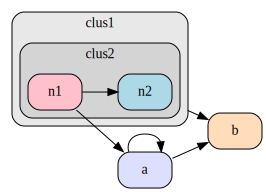

In [ ]:
sg2 = Cluster('clus2')
n1 = sg2.add_item('n1', fillcolor='pink')
n2 = sg2.add_item('n2', fillcolor='lightblue')
sg2.add_item(n1.connect(n2))

sg1 = Cluster('clus1')
sg1.add_item(sg2)

a,b = Node('a'),Node('b')
edges = a.connect(b),a.connect(a),sg1.connect(b),sg2[0].connect(a)
g = Dot()
g.add_items(sg1, a, b, *edges)
g

In [ ]:
#export
def object_connections(conns):
    "Create connections between all pairs in `conns`"
    return [object2graph(a).connect(object2graph(b)) for a,b in conns]

This is a shortcut for creating connections between objects that are already in a graph.

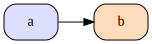

In [ ]:
a,b = 'a','b'
g = graph_items(a, b)
g.add_items(*object_connections([(a,b)]))
g

## Sequential

Since it's common to want to connect a series sequentially, we provide some simple shortcuts for this functionality.

In [ ]:
#export
def graph_edges_seq(items):
    "Add edges between each pair of nodes in `items`"
    return L(items[i].connect(items[i+1]) for i in range(len(items)-1))

In [ ]:
#export
@patch
def add_edges_seq(self:pydot.Graph, items):
    "Add edges between each pair of nodes in `items`"
    return self.add_items(*graph_edges_seq(items))

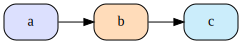

In [ ]:
g = Dot()
its = g.add_items('a','b','c')
g.add_edges_seq(its)
g

In [ ]:
#export
def seq_cluster(items, cluster_label='', **kwargs):
    sg = Cluster(cluster_label)
    its = sg.add_items(*items, **kwargs)
    sg.add_edges_seq(its)
    return sg

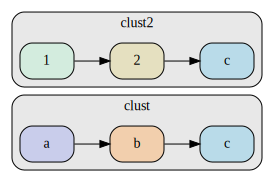

In [ ]:
g = Dot()
g.add_item(seq_cluster(['a','b','c'], 'clust'))
g.add_item(seq_cluster(['1','2','c'], 'clust2'))
g

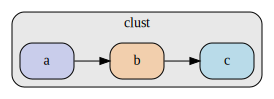

In [ ]:
g = Dot()
g.add_item(seq_cluster(['a','b','c'], 'clust'))
g

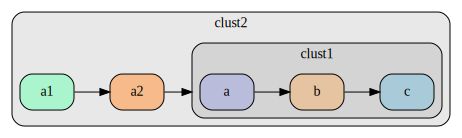

In [ ]:
sg1 = seq_cluster(['a','b','c'], 'clust1')
sg2 = seq_cluster(['a1','a2',sg1], 'clust2')
g = Dot()
g.add_item(sg2)
g

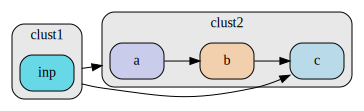

In [ ]:
sg1 = seq_cluster(['inp'], 'clust1')
sg2 = seq_cluster(['a','b','c'], 'clust2')
sg2.add_items(sg1.connect(sg2[-1]), sg1.connect(sg2))
g = Dot()
g.add_items(sg1,sg2)
g

In [ ]:
# export
def Point(label='pnt', **kwargs):
    "Create a `Node` with a 'point' shape"
    return (Node('pnt', shape='point'))

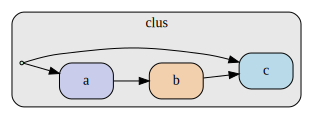

In [ ]:
sg = Cluster('clus')
a,b,c = sg.add_items('a','b','c')
p = sg.add_item(Point())
sg.add_item(p.connect(c))
sg.add_items(p.connect(a), a.connect(b), b.connect(c))

g = Dot()
g.add_items(sg)
g

# Operator Overloading

To make plotting graph potentially easier, we could overload the operator for more intuitive syntax.

In [ ]:
#export
@patch
def __add__(self:pydot.Graph, item, **kwargs):
    "Add a `Cluster`, `Node`, or `Edge` to the `Graph` with operator"
    # if not is_listy(item):
    #     item = L(item)
    if not is_listy(item):
        return self.add_item(item, **kwargs)
    else:
        return self.add_items( *item, **kwargs)

@patch
def __rshift__(self:(pydot.Node,pydot.Graph), item, compass1=None, compass2=None, **kwargs):
    return self.connect(item, compass1, compass2, **kwargs)

    
def is_listy(x)->bool:
    return isinstance(x, (tuple,list))

In Python, there are some magic method like __add__ and __rshift__ which correspond to `+` and `>>`. We can take advantage of this to make our syntax simpler. We basically replace `add_item` and `add_items` with `+` and `connect` with `>>`.

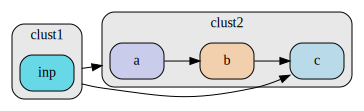

In [ ]:
sg1 = seq_cluster(['inp'], 'clust1')
sg2 = seq_cluster(['a','b','c'], 'clust2')
sg2 + (sg1 >> (sg2[-1]), sg1 >> (sg2))
g = Dot()
g +(sg1,sg2)
g

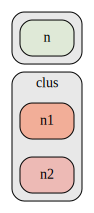

In [ ]:
sg1 = Cluster('clus')
sg1 + ('n1', 'n2')
sg2 = Cluster()
sg2 + ('n')
graph_items(sg1,sg2)

A more complex example

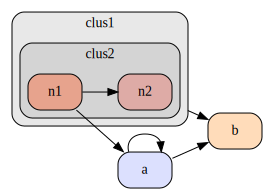

In [ ]:
sg2 = Cluster('clus2')
n1 = sg2 + 'n1'
n2 = sg2 + 'n2'
sg2 + n1.connect(n2)
sg1 = Cluster('clus1')
sg1 + (sg2)

a, b = Node('a'), Node('b')
edges = a >>(b), a >>(a), sg1 >>(b), sg2[0] >>(a)
g = Dot()
g + (sg1, a, b, *edges)
a, b = Node('a'), Node('b')
g


First we construct the two cluster.

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
